In [8]:
!pip install transformers torch pandas scikit-learn evaluate keras seaborn

  Using cached scikit_learn-1.2.2-cp39-cp39-win_amd64.whl (8.4 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)


In [3]:
%%time
import os
import pandas as pd

directory = 'data/jsons'

dfs = [] # an empty list to store the data frames
for f in os.listdir(directory):
    file = os.path.join(directory, f)
    data = pd.read_json(file, typ='series').to_frame().T # read data frame from json file
    dfs.append(data) # append the data frame to the list

df = pd.concat(dfs, ignore_index=True)
df

CPU times: total: 53.7 s
Wall time: 53.7 s


,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,terrorism,New York Times - News,0,http://www.nytimes.com/2016/09/20/nyregion/ahm...,"Bomb Suspect Changed After Trip Abroad, Friend...",2016-09-20,N. R. Kleinfield,"Besides his most recent trip to Quetta , Mr. R...","Besides his most recent trip to Quetta, Mr. Ra...",www.nytimes.com,left,004Gt3gcsotuiYmz
1,supreme_court,Vox,0,https://www.vox.com/policy-and-politics/2018/9...,Why Susan Collins claims she’s being bribed ov...,2018-09-12,"Emily Stewart, Terry Nguyen, Rebecca Jennings,...",Is Maine Republican Sen. Susan Collins being b...,Is Maine Republican Sen. Susan Collins being b...,www.vox.com,left,00eP4XD3VdMmHITE
2,education,Ezra Klein,0,http://www.npr.org/blogs/thetwo-way/2014/05/06...,Poll: Prestigious Colleges Won't Make You Happ...,2014-05-06,Anya Kamenetz,Poll : Prestigious Colleges Wo n't Make You Ha...,Poll: Prestigious Colleges Won't Make You Happ...,www.npr.org,left,00FTGIZEd6B8zQ4U
3,us_house,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Paul Ryan Reportedly Says No Chance for Border...,2017-09-12,Ian Mason,"House Speaker Paul Ryan , at a private dinner ...","House Speaker Paul Ryan, at a private dinner e...",www.breitbart.com,right,00HGGqBRf1kzPRlg
4,white_house,Guest Writer - Left,0,https://www.cnn.com/2019/07/11/politics/donald...,OPINION: Trump seeking change of legal fortune...,2019-07-11,Analysis Stephen Collinson,( CNN ) President Donald Trump has reason to h...,(CNN) President Donald Trump has reason to hop...,www.cnn.com,left,00IzI5ynahBVtC9l
...,...,...,...,...,...,...,...,...,...,...,...,...
37549,race_and_racism,Yahoo! The 360,1,https://news.yahoo.com/how-do-we-address-racis...,How do we address racism in 'Gone With the Wind'?,2020-06-18,Julia Munslow,“ The 360 ” shows you diverse perspectives on ...,“The 360” shows you diverse perspectives on th...,www.news.yahoo.com,center,zzwPV6NCYsMiDb0a
37550,elections,The Hill,1,https://thehill.com/homenews/campaign/445504-t...,The top 10 Democrats in the 2020 race,2019-05-28,,The race for the Democratic presidential nomin...,The race for the Democratic presidential nomin...,www.thehill.com,center,zZwwVzN0ZltBq302
37551,violence_in_america,Townhall,2,https://townhall.com/tipsheet/leahbarkoukis/20...,Report: Police Questioned YouTube Shooter Morn...,2018-04-04,"Leah Barkoukis, Matt Vespa, Timothy Meads, Kat...",Police confirmed they found and questioned Nas...,Police confirmed they found and questioned Nas...,www.townhall.com,right,ZzXppS8L4v4WsVWq
37552,free_speech,NPR Online News,1,http://www.npr.org/blogs/parallels/2015/02/10/...,The French Debate: Free Speech Versus Hate Speech,2015-02-10,Eleanor Beardsley,When terrorists attacked a satirical magazine ...,The French Debate: Free Speech Versus Hate Spe...,www.npr.org,center,zzZMTdCEiAiVRRO3


In [8]:
df.drop(['topic', 'source', 'url', 'title', 'date', 'authors', 'content_original', 'source_url', 'bias_text', 'ID'],
        axis=1, inplace=True)
df

KeyError: "['topic', 'source', 'url', 'title', 'date', 'authors', 'content_original', 'source_url', 'bias_text', 'ID'] not found in axis"

In [9]:
df['content'] = df['content'].str.replace('[^\w\s]','')
df['content'] = df['content'].str.lower()

df.head()

,bias,content
0,0,"besides his most recent trip to quetta , mr. r..."
1,0,is maine republican sen. susan collins being b...
2,0,poll : prestigious colleges wo n't make you ha...
3,2,"house speaker paul ryan , at a private dinner ..."
4,0,( cnn ) president donald trump has reason to h...


In [10]:
import torch; torch.cuda.is_available()

True

In [11]:
import numpy as np
'''
get average article word length to use as word count limit for LSTM, 
articles that are shorter than this will be zero-padded
Use 1/3 of this length for training time for now
'''
max_length = int(np.round(df['content'].apply(len).mean()) / 3)
max_length

1949

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [13]:
%%time
from sklearn.model_selection import train_test_split
from tensorflow import keras

X_train, X_test, y_train, y_test = train_test_split(df, df['bias'].to_numpy(), test_size=0.1, stratify=df['bias'].to_numpy())
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1.0/9.0, stratify=y_train)

NUM_CLASSES = len(np.unique(df['bias']))
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
y_val_ohe = keras.utils.to_categorical(y_val, NUM_CLASSES)

print(len(X_train), len(X_test), len(X_val))

30042 3756 3756
CPU times: total: 1.69 s
Wall time: 2.06 s


In [14]:
#model_name = "bert-base-uncased"
#model_name = "allenai/longformer-base-4096"
model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to("cuda")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

In [18]:
# Uncomment to load pretrained
#from transformers import AutoModel
# model = AutoModel.from_pretrained('article-bias-2',local_files_only=True)

Some weights of the model checkpoint at article-bias-2 were not used when initializing DistilBertModel: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
%%time
def encode(texts, tokenizer, max_length=512):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

train_encodings = encode(X_train['content'].tolist(), tokenizer)
test_encodings = encode(X_test['content'].tolist(), tokenizer)
eval_encodings = encode(X_val['content'].tolist(), tokenizer)

CPU times: total: 3min 24s
Wall time: 1min 14s


In [20]:
from torch.utils.data import Dataset

class PoliticalBiasDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PoliticalBiasDataset(train_encodings, y_train)
test_dataset = PoliticalBiasDataset(test_encodings, y_test)
eval_dataset = PoliticalBiasDataset(eval_encodings, y_val)

In [21]:
import evaluate

accuracy = evaluate.load("accuracy")
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [19]:
%%time
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=2e-5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

C:\Users\localtoast\anaconda3\envs\article-bias\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.258100,0.849436,0.756922
2,0.172500,0.779403,0.818956
3,0.170300,0.845128,0.813099
4,0.087500,0.957974,0.818158


CPU times: total: 24min 54s
Wall time: 24min 55s


TrainOutput(global_step=7512, training_loss=0.1825564623640749, metrics={'train_runtime': 1495.7362, 'train_samples_per_second': 80.34, 'train_steps_per_second': 5.022, 'total_flos': 1.5918626242732032e+16, 'train_loss': 0.1825564623640749, 'epoch': 4.0})

In [20]:
trainer.save_model('article-bias-2')

In [21]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [22]:
trainer.evaluate()

{'eval_loss': 0.7794026732444763,
 'eval_accuracy': 0.8189563365282215,
 'eval_runtime': 14.7356,
 'eval_samples_per_second': 254.893,
 'eval_steps_per_second': 15.948,
 'epoch': 4.0}

In [25]:
from transformers import pipeline
pipe = pipeline("text-classification", model='article-bias-2', tokenizer=tokenizer)

In [26]:
s = df.iloc[3]['content']
s = ' '.join(s.split()[:400])
print(s)
pipe(s)

house speaker paul ryan , at a private dinner earlier this year , said he thought only “ one member ” wanted to build a wall across the entire u.s.-mexico border , ███ has learned from multiple sources with direct knowledge of the comments , including former rep. tom tancredo ( r-co ) . the dinner , sources said , took place on the eve of the house ’ s passage of two relatively minor immigration bills at the end of june : kate ’ s law and sanctuary city reforms . the far wider reaching davis-oliver act was tabled at the same time . “ ryan told a group of republicans he met with … that only one person wants a wall , ” tancredo told ███ shortly after the dinner . tancredo took issue with the speaker ’ s characterization of support for the wall within the house gop . “ of course he means only one person in his entourage and of the leadership , ” he told ███ . “ i know several people in congress who want a wall and i know that there are millions of americans who want a wall . ” “ you have 

[{'label': 'LABEL_2', 'score': 0.9938127994537354}]

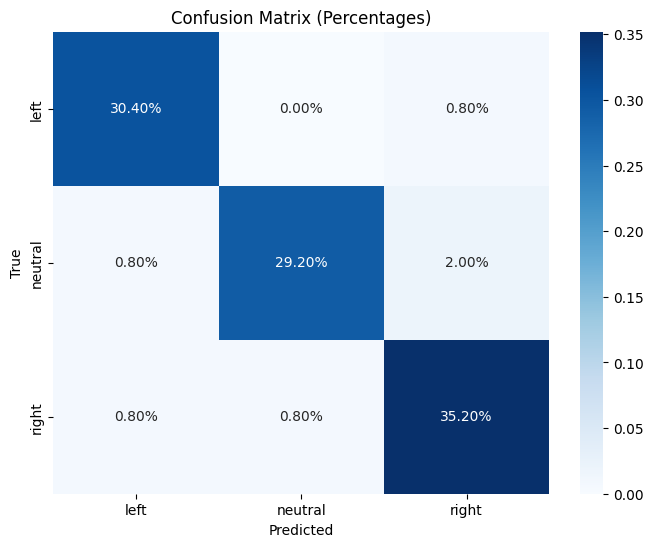

CPU times: total: 7min 4s
Wall time: 54.4 s


In [27]:
%%time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


labels = ["left", "neutral", "right"]

def get_label_indices(predictions):
    labels = ["LABEL_0", "LABEL_1", "LABEL_2"]  # Adjust these labels to match the output of your model
    return [labels.index(pred["label"]) for pred in predictions]

def truncate_text(text, tokenizer, max_length=512):
    tokens = tokenizer.tokenize(text)
    truncated_tokens = tokens[:max_length - 2]  # Reserve space for special tokens [CLS] and [SEP]
    truncated_text = tokenizer.convert_tokens_to_string(truncated_tokens)
    return truncated_text

test_texts = X_val['content'][:250]
truncated_texts = [truncate_text(t, tokenizer) for t in test_texts]
test_preds = pipe(truncated_texts)
test_pred_indices = get_label_indices(test_preds)
test_true_indices = list(y_val[:250])


def plot_confusion_matrix(confusion_matrix, labels):
    # Normalize the confusion matrix
    cm_normalized = confusion_matrix.astype(float) / confusion_matrix.sum()
    
    # Create a DataFrame from the normalized confusion matrix
    df_cm = pd.DataFrame(cm_normalized, index=labels, columns=labels)
    
    # Plot the heatmap with percentage annotations
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt=".2%", cmap="Blues")
    plt.title("Confusion Matrix (Percentages)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

cm = confusion_matrix(test_true_indices, test_pred_indices)
plot_confusion_matrix(cm, ["left", "neutral", "right"])

In [37]:
test_true_indices

array([1, 0, 2, 2, 0, 1, 2, 1, 0, 1], dtype=object)

In [38]:
test_pred_indices

[1, 0, 2, 2, 0, 0, 2, 1, 0, 1]